In [1]:
import sys
import numpy as np
import pandas as pd

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import imageio
from IPython.display import Image, display

sns.set()

# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default') 

print( f"Python {sys.version}" )
print( f"Pandas {pd.__version__}" )
print( f"NumPy {np.__version__}" )
print( f"Matplotlib {mpl.__version__}" )

Python 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
Pandas 1.3.4
NumPy 1.20.3
Matplotlib 3.4.3


In [2]:
#set encoding to ignore special charaters
satellite = pd.read_csv("space_missions.csv",encoding="ISO-8859-1")
satellite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company        4630 non-null   object
 1   Location       4630 non-null   object
 2   Date           4630 non-null   object
 3   Time           4503 non-null   object
 4   Rocket         4630 non-null   object
 5   Mission        4630 non-null   object
 6   RocketStatus   4630 non-null   object
 7   Price          1265 non-null   object
 8   MissionStatus  4630 non-null   object
dtypes: object(9)
memory usage: 325.7+ KB


/var/folders/qk/5_83kjh940l41l8fjcv9nq080000gn/T/ipykernel_48281/1163669400.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country'][df['Country'] == 'Shahrud Missile Test Site'] = 'Iran'
/var/folders/qk/5_83kjh940l41l8fjcv9nq080000gn/T/ipykernel_48281/1163669400.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax = ax.set_xticklabels(year, rotation=90, ha='right')


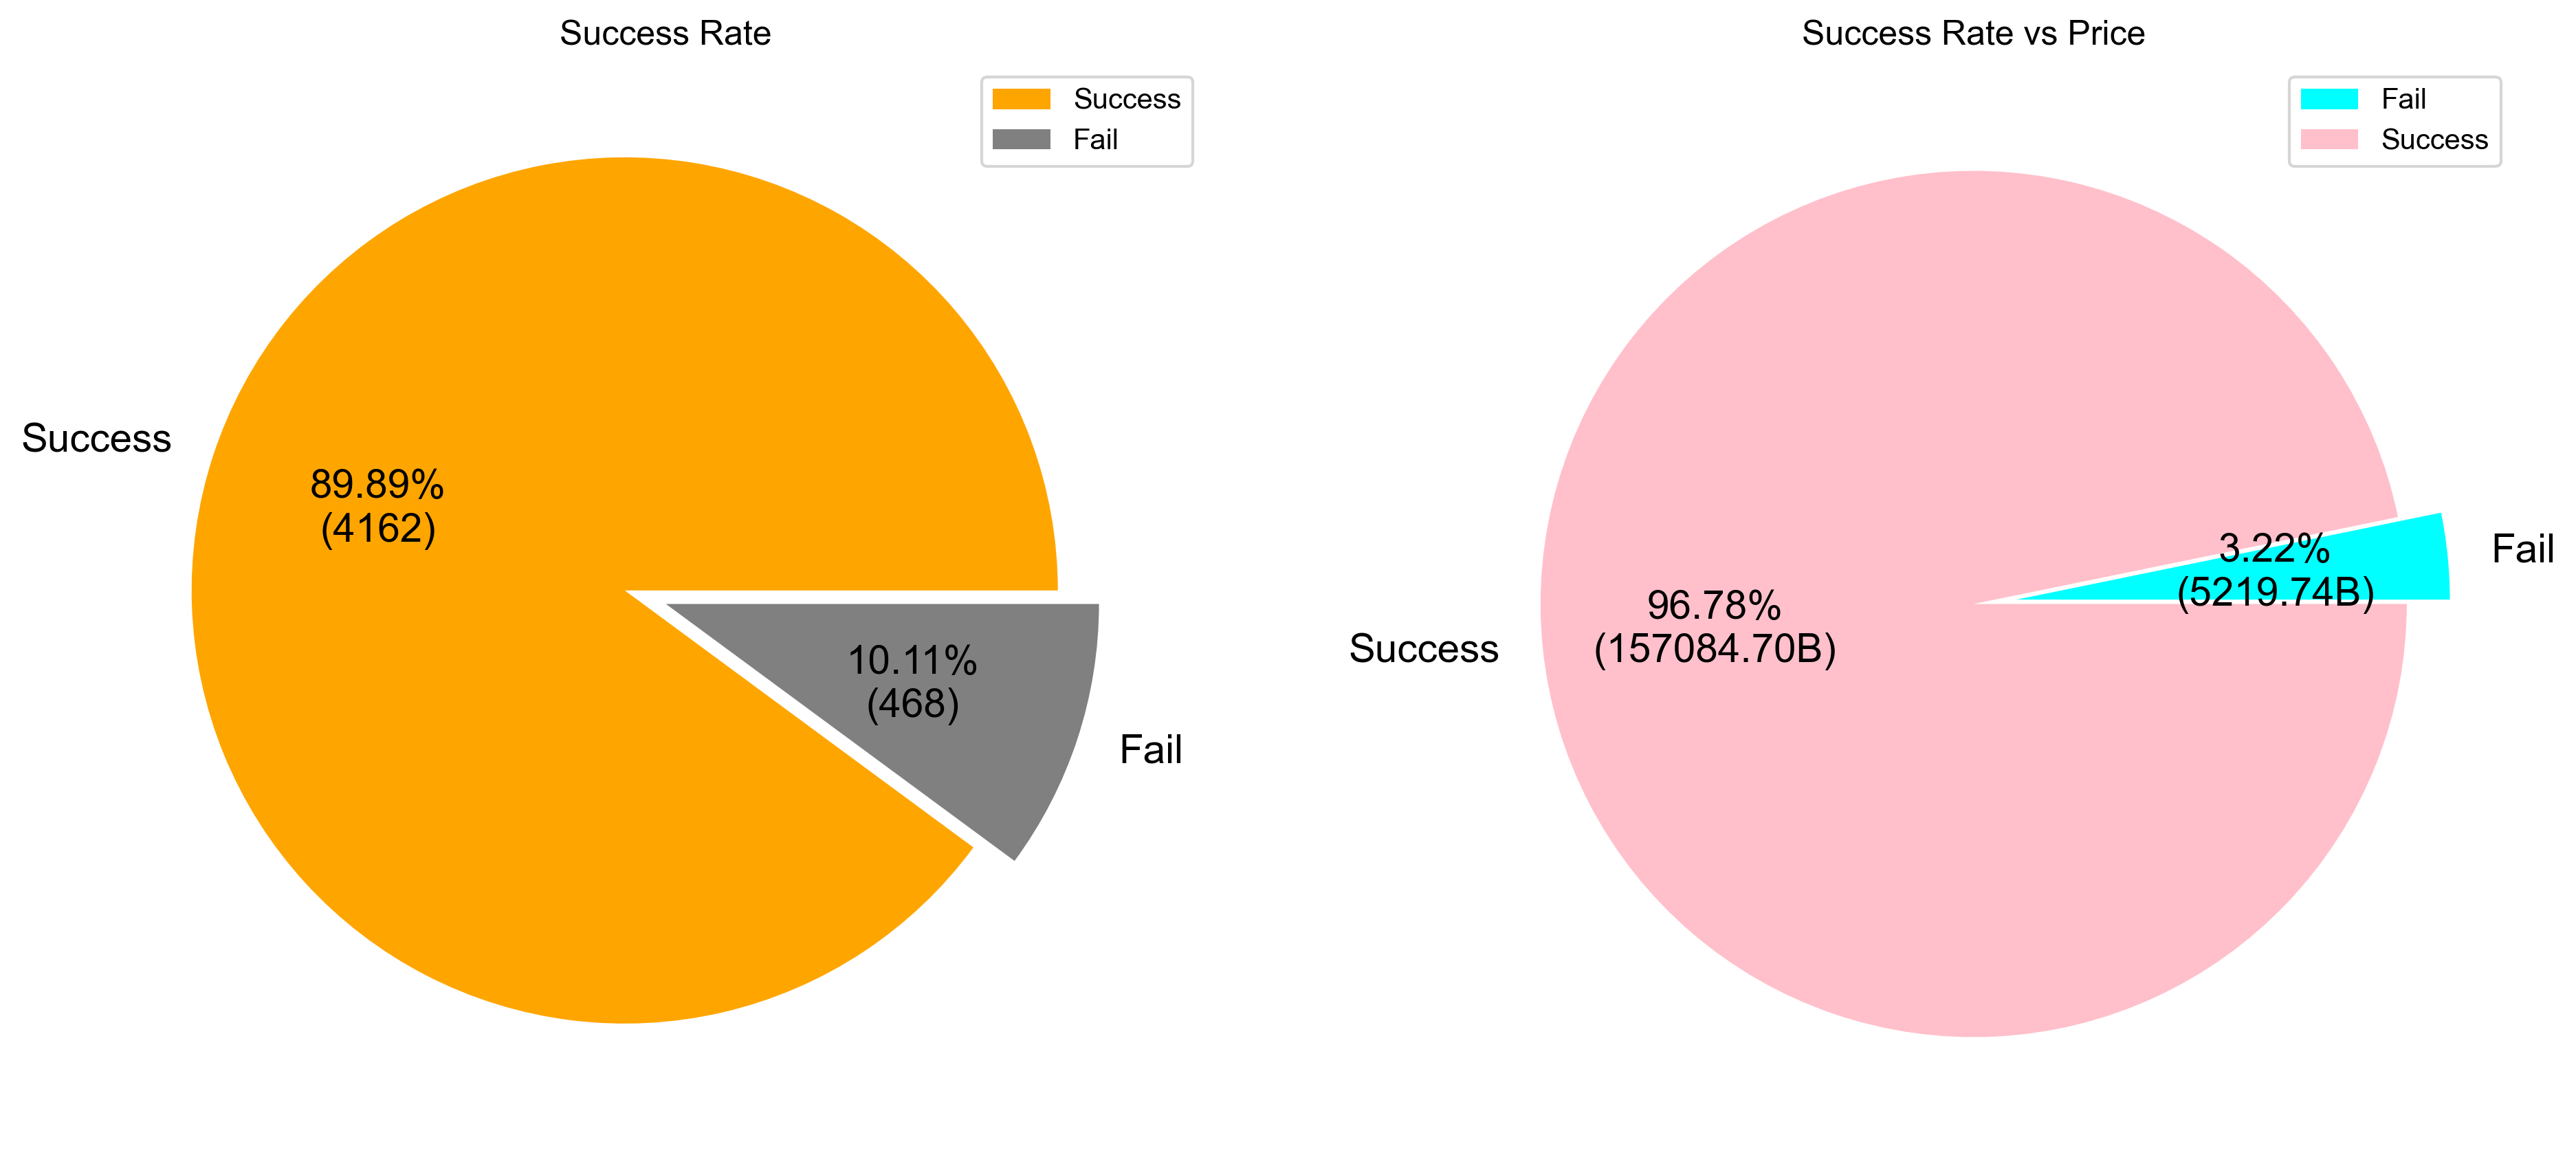

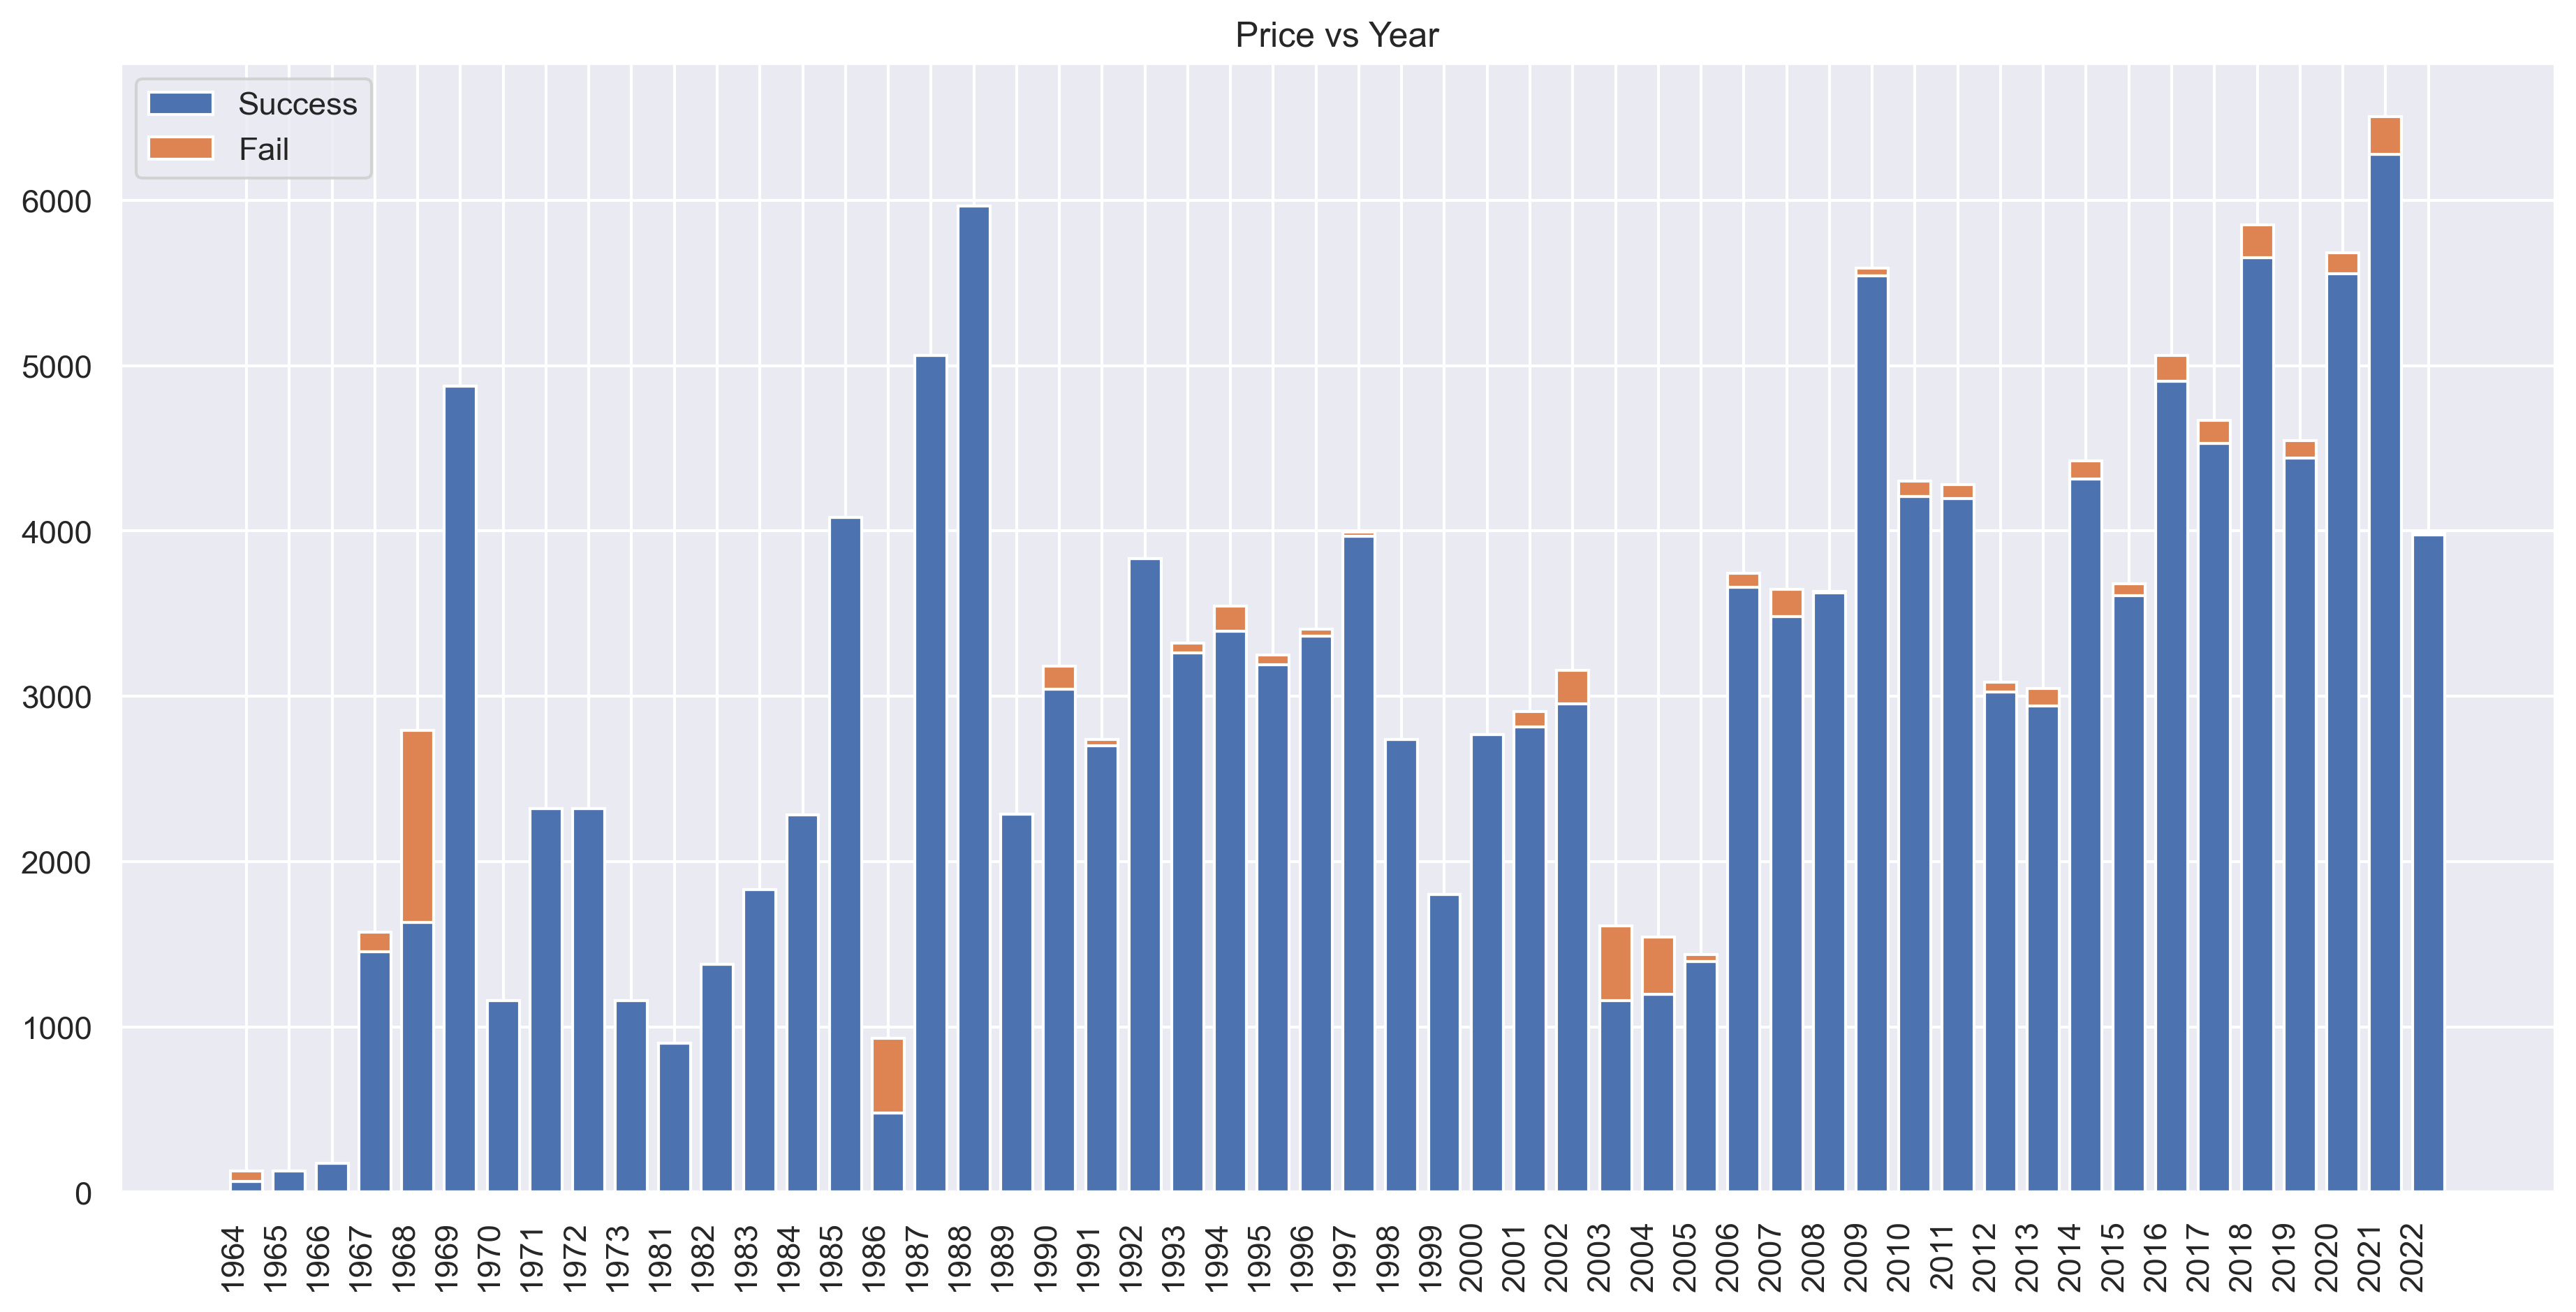

In [3]:
#Clean Data
df = satellite.copy()
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Country'] = df['Location'].str.split(",").str[-1]
df['Country'] = df['Country'].apply(lambda x: x.strip())
#Shahrud Missile Test Site = Iran
df['Country'][df['Country'] == 'Shahrud Missile Test Site'] = 'Iran'

df_analyze2 = df.loc[:,['Price','MissionStatus']]
df_analyze2['MissionStatus'] = df_analyze2['MissionStatus'].apply(lambda x: 1 if x=='Success' else 0 )
dfgraph2 = df_analyze2['MissionStatus'].value_counts(ascending=False)

df.dropna(subset=['Price'],inplace=True)
df['Price'] = df['Price'].apply(lambda x: x.replace(',',''))
df['Price'] = df['Price'].astype(np.float32)
df_analyze1 = df.loc[:,['Year','Price','MissionStatus']]

df_analyze1['MissionStatus'] = df_analyze1['MissionStatus'].apply(lambda x: 1 if x=='Success' else 0 )
dfgraph1 = df_analyze1.pivot_table( index='MissionStatus', values='Price', aggfunc='sum' )
dfgraph1 = dfgraph1.fillna(0)

dfgraph3 = df_analyze1.pivot_table( index='Year',
                                   columns='MissionStatus', 
                                   values='Price', 
                                   aggfunc='sum' )
dfgraph3 = dfgraph3.fillna(0)

#Plot
fig = plt.figure(figsize=(15,15), dpi=300)

ax1 = plt.subplot2grid((2,2),(0,0))
plt.pie(dfgraph2, labels = ['Success','Fail'], 
        autopct= lambda x: '{:.2f}%\n({:.0f})'.format(x,x*dfgraph2.sum()/100), 
        shadow=False, 
        colors = ['Orange','Gray'], 
        explode = (0.1, 0.0), 
        textprops = dict(fontsize = 14))
plt.legend(['Success','Fail'], loc='upper right')
plt.title('Success Rate')

ax1 = plt.subplot2grid((2,2),(0,1))
plt.pie(dfgraph1['Price'], labels = ['Fail','Success'],
        autopct= lambda x: '{:.2f}%\n({:.2f}B)'.format(x,x*dfgraph1['Price'].sum()/100),
        shadow=False,
        colors = ['Cyan','Pink'],
        explode = (0.1, 0.0),
        textprops = dict(fontsize = 14))
plt.legend(['Fail','Success'], loc='upper right')
plt.title('Success Rate vs Price')

sns.set(rc={'figure.figsize':(15,7),'figure.dpi':300})
fig,ax = plt.subplots(figsize=(15,7),dpi=300)
year = df_analyze1['Year'].unique()
year = [str(x) for x in year]
p1 = plt.bar(year, dfgraph3[1].values.tolist(), 0.75, )
p2 = plt.bar(year, dfgraph3[0].values.tolist(), 0.75, bottom = dfgraph3[1].values.tolist())
plt.legend(['Success','Fail'], loc='upper left')
ax = ax.set_xticklabels(year, rotation=90, ha='right')
plt.title('Price vs Year')

plt.show()

/var/folders/qk/5_83kjh940l41l8fjcv9nq080000gn/T/ipykernel_48281/916491613.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country'][df['Country'] == 'Shahrud Missile Test Site'] = 'Iran'


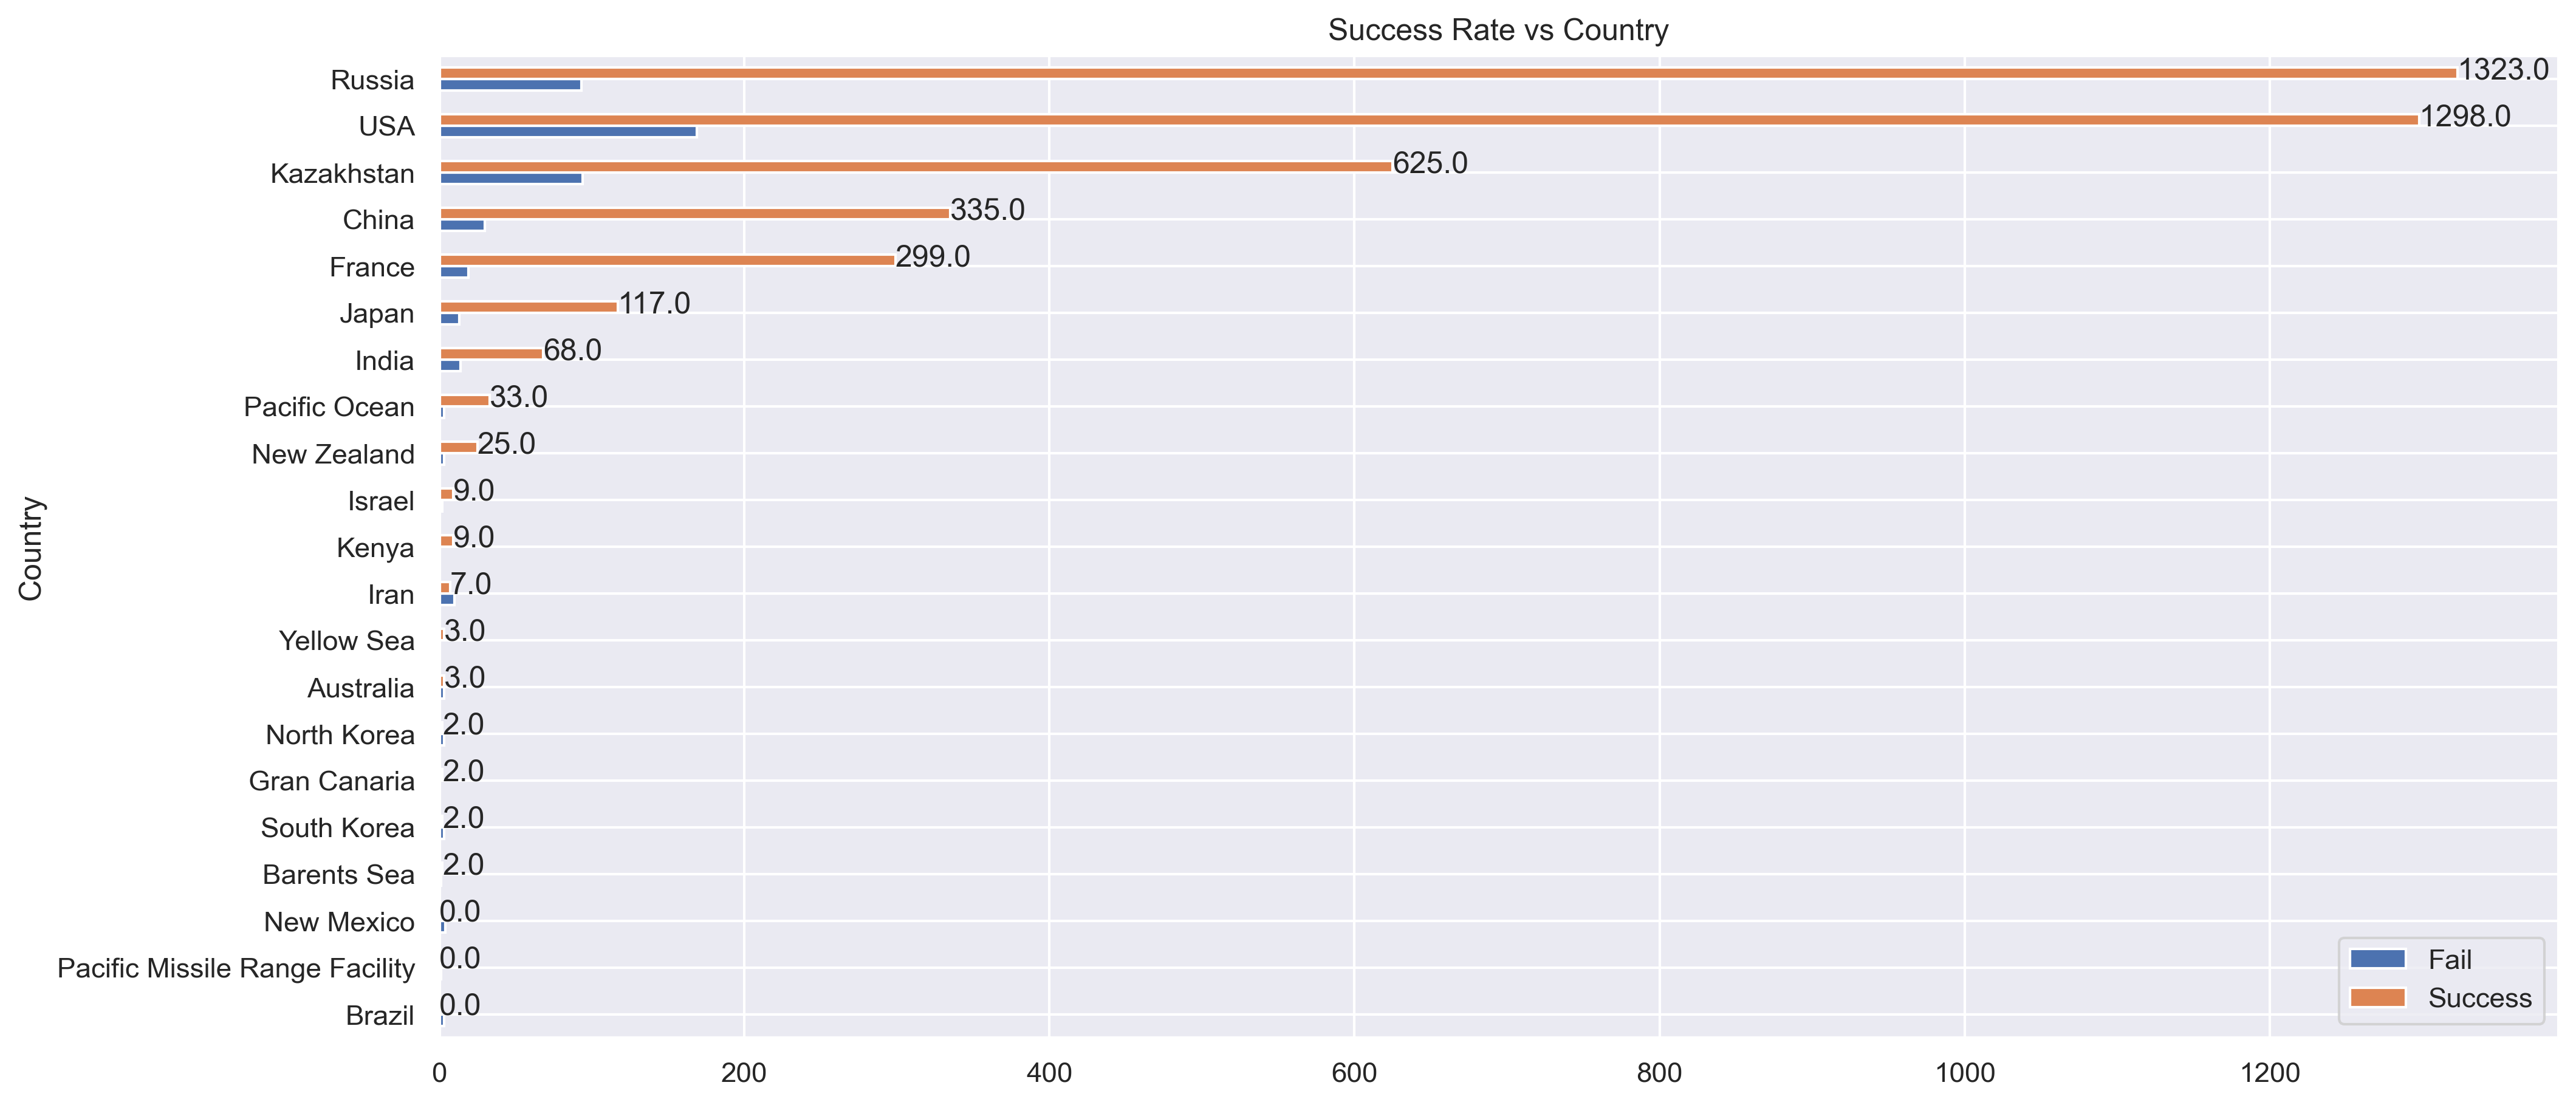

In [4]:
#Clean Data
df = satellite.copy()
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Country'] = df['Location'].str.split(",").str[-1]
df['Country'] = df['Country'].apply(lambda x: x.strip())
#Shahrud Missile Test Site = Iran
df['Country'][df['Country'] == 'Shahrud Missile Test Site'] = 'Iran'

df_analyze2 = df.loc[:,['Year','Country','MissionStatus']]
df_analyze2['MissionStatus'] = df_analyze2['MissionStatus'].apply(lambda x: 1 if x=='Success' else 0 )
dfgraph2 = df_analyze2.pivot_table( index='Country',
                                   columns='MissionStatus', 
                                   values='MissionStatus', 
                                   aggfunc='count' )
dfgraph2 = dfgraph2.fillna(0)
dfgraph2 = dfgraph2.sort_values(by=[1],ascending=True)

#Plot
sns.set(rc={'figure.figsize':(15,7),'figure.dpi':300})
ax = dfgraph2.plot.barh(ax=plt.axes())
ax.legend(['Fail','Success'],loc='lower right')
ax = ax.set_title('Success Rate vs Country')
for index, value in enumerate(dfgraph2[1]):
    plt.text(value, index, str(value))

/var/folders/qk/5_83kjh940l41l8fjcv9nq080000gn/T/ipykernel_48281/2825509716.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country'][df['Country'] == 'Shahrud Missile Test Site'] = 'Iran'


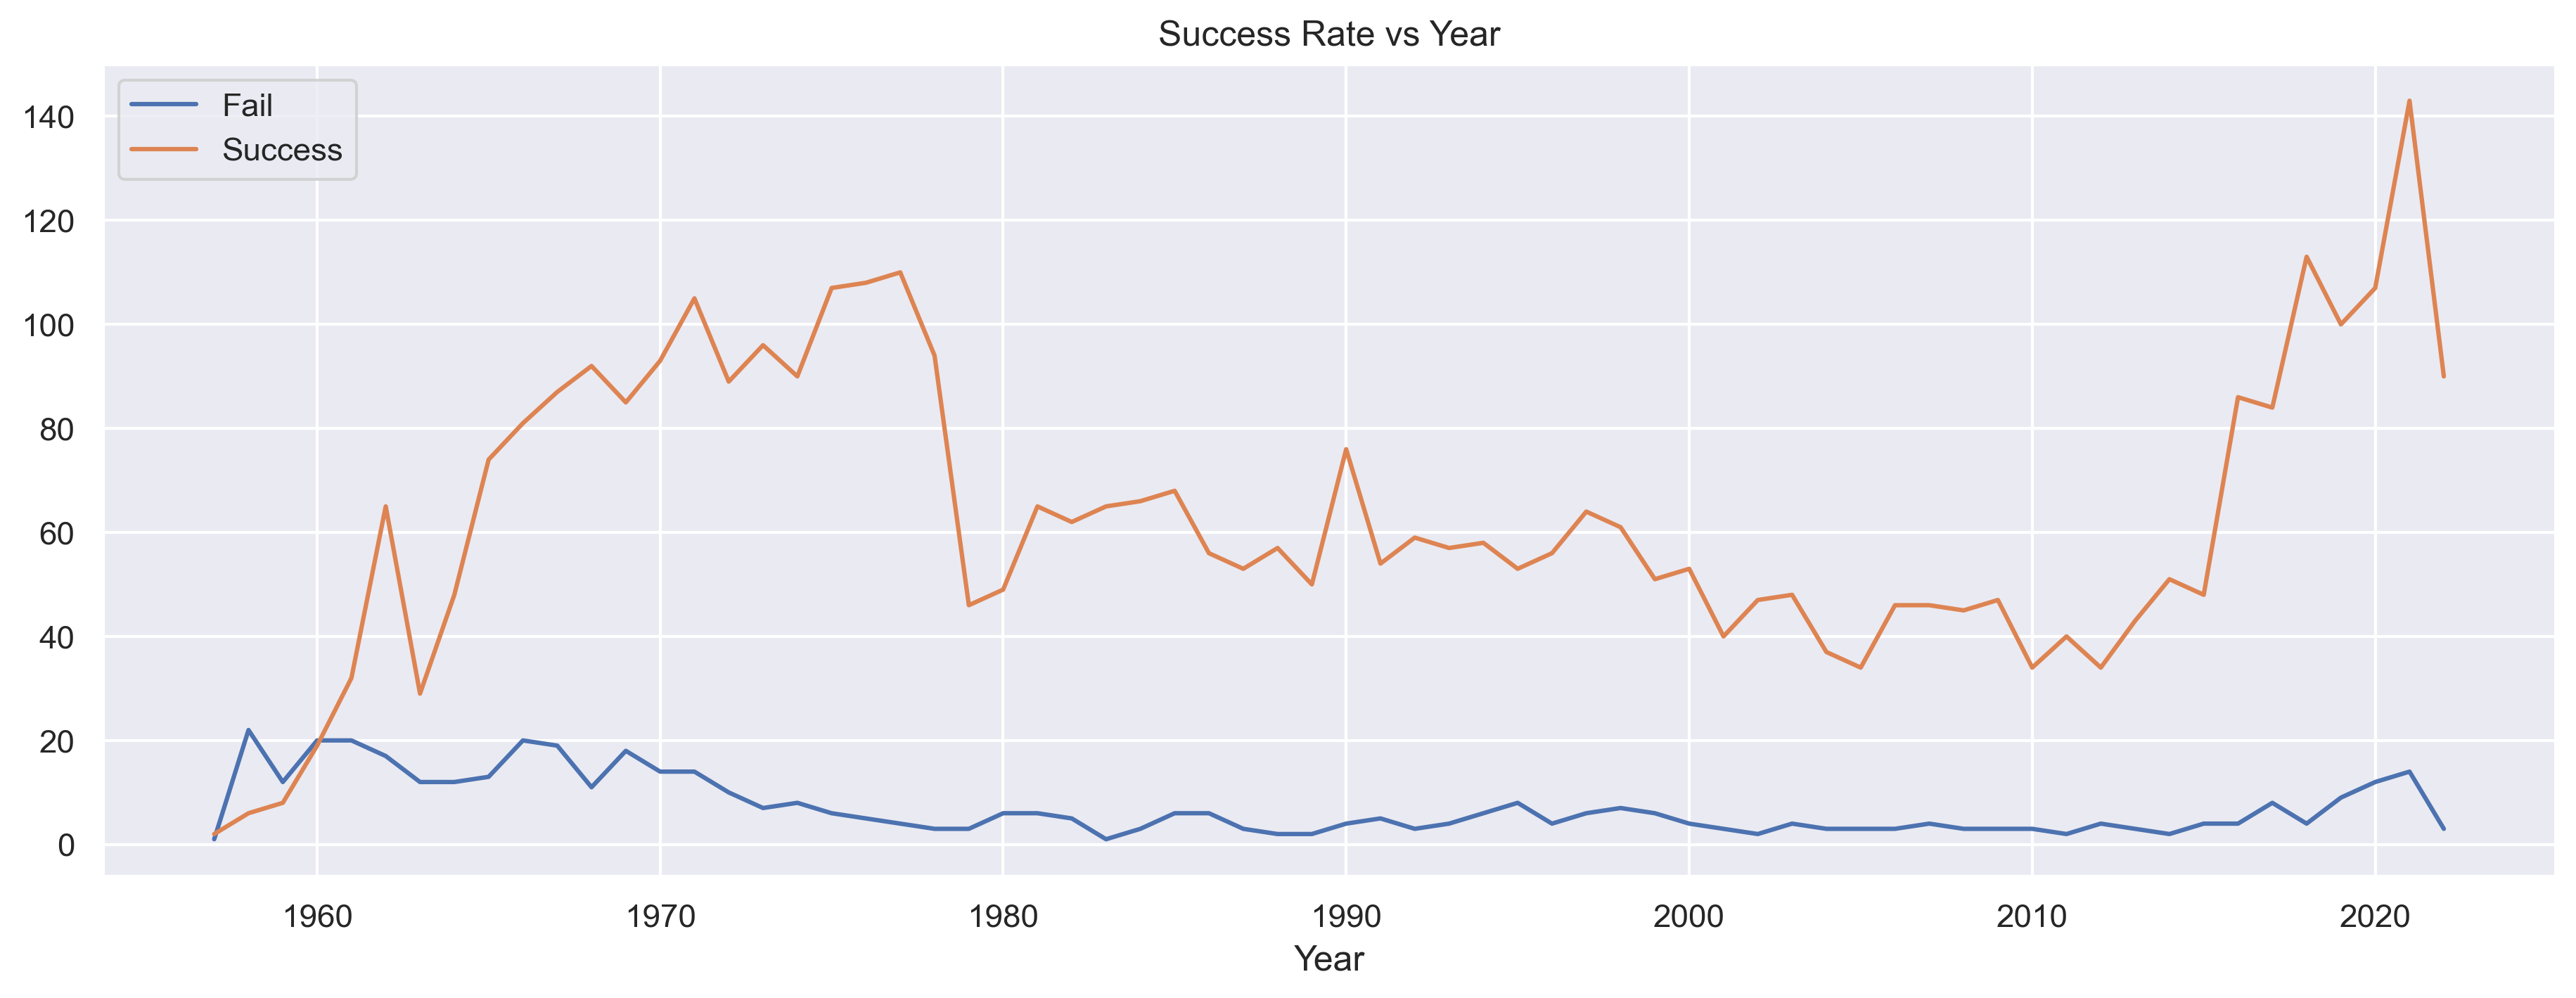

In [5]:
#Clean Data
df = satellite.copy()
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Country'] = df['Location'].str.split(",").str[-1]
df['Country'] = df['Country'].apply(lambda x: x.strip())
#Shahrud Missile Test Site = Iran
df['Country'][df['Country'] == 'Shahrud Missile Test Site'] = 'Iran'

df_analyze3 = df.loc[:,['Year','Country','MissionStatus']]
df_analyze3['MissionStatus'] = df_analyze3['MissionStatus'].apply(lambda x: 1 if x=='Success' else 0 )
dfgraph3 = df_analyze3.pivot_table( index='Year',
                                   columns='MissionStatus', 
                                   values='MissionStatus', 
                                   aggfunc='count' )
dfgraph3 = dfgraph3.fillna(0)

sns.set(rc={'figure.figsize':(15,5),'figure.dpi':300})
ax = dfgraph3.plot(ax=plt.axes())
ax.legend(['Fail','Success'],loc='upper left')
ax = ax.set_title('Success Rate vs Year')

In [6]:
#Clean Data
df = satellite.copy()
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Country'] = df['Location'].str.split(",").str[-1]
df['Country'] = df['Country'].apply(lambda x: x.strip())
#Shahrud Missile Test Site = Iran
df['Country'][df['Country'] == 'Shahrud Missile Test Site'] = 'Iran'

df_analyze = df[['Year','Country','Price','MissionStatus']][df['MissionStatus']=='Success']
df_analyze['MissionStatus'] = 1

dfgraph = df_analyze.pivot_table( index='Year', columns='Country', values='MissionStatus', aggfunc='count' )
dfgraph = dfgraph.fillna(0)

# frames between transitions
n_frames = 10

x = np.unique(df_analyze['Country'].values.tolist(),return_index=False)
print('Creating charts\n')
filenames = []
year = df_analyze['Year'].unique()
for j,index in enumerate(year):
    # get current and next y coordinates
    if j == len(year)-1:
        break
    y = dfgraph.loc[year[j]].values.tolist()
    y1 = dfgraph.loc[year[j+1]].values.tolist()
    
    # calculate the distance to the next position
    y_path = np.array(y1) - np.array(y)
    for i in np.arange(0, n_frames + 1):
        # divide the distance by the number of frames 
        # and multiply it by the current frame number
        y_temp = (y + (y_path / n_frames) * i)
        # plot
        fig,ax = plt.subplots(figsize=(20,5),dpi=150)
        plt.bar(x, y_temp)
        plt.ylim(0,75)
        ax = ax.set_xticklabels(x, rotation=45, ha='right')
        title = fig.suptitle('Year '+str(year[j]))
        # build file name and append to list of file names
        filename = f'images/frame_{index}_{i}.png'
        filenames.append(filename)
        # last frame of each viz stays longer
        if (i == n_frames):
            for i in range(5):
                filenames.append(filename)
        # save img
        plt.savefig(filename,bbox_inches='tight')
        plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer('graph6.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('DONE')

/var/folders/qk/5_83kjh940l41l8fjcv9nq080000gn/T/ipykernel_48281/3821419966.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country'][df['Country'] == 'Shahrud Missile Test Site'] = 'Iran'
/var/folders/qk/5_83kjh940l41l8fjcv9nq080000gn/T/ipykernel_48281/3821419966.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax = ax.set_xticklabels(x, rotation=45, ha='right')


Creating charts

Charts saved

Creating gif

Gif saved

Removing Images

DONE
